<a id='top'></a>

# Physical  Data Engineering, Part 2
##### Notebook to engineer the second of two provided datasets of physical data by [Watford F.C](https://www.watfordfc.com/), using [Python](https://www.python.org/) [pandas](http://pandas.pydata.org/).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 11/02/2022<br>
Notebook last updated: 12/02/2022

![Watford F.C.](../../img/club_badges/premier_league/watford_fc_logo_small.png)

Click [here](#section4) to jump straight into the Data Engineering section and skip the [Notebook Brief](#section2) and [Data Sources](#section3) sections.

___


## <a id='introduction'>Introduction</a>
This notebook engineers a second of two provided datasets of physical data by [Watford F.C](https://www.watfordfc.com/), using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/); and
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

A static version of this notebook can be found [here](https://nbviewer.org/github/eddwebster/watford/blob/main/notebooks/2_data_engineering/Physical%20Data%20Engineering%20Part%202.ipynb). This notebook has an accompanying [`watford`](https://github.com/eddwebster/watford) GitHub repository and for my full repository of football analysis, see my [`football_analysis`](https://github.com/eddwebster/football_analytics) GitHub repository.

___

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Notebook Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Read in the Datasets](#section3.2)<br>
      3.    [Initial Data Handling](#section3.3)<br>
4.    [Data Engineering](#section4)<br>
      1.    [Prepare Training Data](#section4.1)<br>
      2.    [Split Out Unified Training Data into Individual Training Drills](#section4.2)<br>
      3.    [Engineer DataFrame to Match Tracking Data Format](#section4.3)<br>
      4.    [Calculate Speed, Distance, and Acceleration](#section4.4)<br>
      5.    [Create Physical Reports for Each Individual Training Session](#section4.5)<br>
      6.    [Create Single Physical Report for the Day of Interest](#section4.6)<br>
5.    [Summary](#section5)<br>
6.    [Next Steps](#section6)<br>
7.    [References](#section7)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://www.python.org/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing; and
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation.

All packages used for this notebook can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import pandas_profiling as pp
import os
import re
import chardet
import random
from io import BytesIO
from pathlib import Path

# Reading Directories
import glob
import os

# Working with JSON
import json
from pandas import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Machine learning
import scipy.signal as signal

# Requests and downloads
import tqdm
import requests

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Print message
print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.19.1
pandas: 1.1.3
matplotlib: 3.3.1


### Defined Filepaths

In [3]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_physical = os.path.join(base_dir, 'data', 'physical')
scripts_dir = os.path.join(base_dir, 'scripts')
models_dir = os.path.join(base_dir, 'models')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')

### Notebook Settings

In [4]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

---

<a id='section2'></a>

## <a id='#section2'>2. Notebook Brief</a>
This notebook parses and engineers a provided dataset of physical data using [pandas](http://pandas.pydata.org/).


**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
The physical data...

<a id='section3.2'></a>

### <a id='#section3.2'>3.2. Import Data</a>
The `CSV` files provided will be read in as [pandas](https://pandas.pydata.org/) DataFrames.

In [5]:
# Read data directory
print(glob.glob(os.path.join(data_dir_physical, 'raw', 'Set 2', '*')))

[]


##### Unify Training data

In [8]:
# Define function for unifying all the training data for a an indicated date into unified DataFrames
def unify_training_data(date): 

    """
    Define a function to unify all the training data for a single data, defined in the function's parameter
    of the formation 'YYYY-MM-DD'
    
    For this example dataset, there is data for just '2022-02-02'
    
    # KEY STEPS
    # - USE GLOB TO PRODUCE SEPARATE DATAFRAMES FOR THE FOLLOWING:
    ##  + ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY
    ##  + CROSSING-AND-FINISHING-HSR-SPR
    ##  + FULL-SESSION-MODIFIED
    ##  + MATCH-MSG
    ##  + PASSING-DRILL-PHYSICAL
    ##  + WARM-UP-COORDINATION-AGILITY
    # - THESE UNIFIED DATAFRAMES NEED TO INCLUDE NEW COLUMNS FOR DATE (FILENAME) AND PLAYER NAME (FILENAME OR COLUMM)
    # - AT THIS STAGE, THE UNIFIED DATAFRAMES CAN BE EXPORTED AS ENGINEERED FILES, BUT UNIFIED
    # - NEXT, DROP ALL COLUMNS EXCEPT: Player Display Name, Time, Lat, Lon, Speed (m/s)
    # - DEDUPLICATE THE DATAFRAME, MANY COLUMNS REMOVED ONCE GYRO DATA IGNORED
    # - USE Player Display Name TO RENAME THE COLUMNS FOR Time, Lat, Lon, Speed (m/s), TO PREFIX WITH NAME
    # - THEN DROP Player Display Name
    # - USE LAURIE'S METRICA SCRIPT TO CALCULATE THE SPEED, DISTANCE, AND ACCELERATION USING THE LAT/LON AND TIMESTEP
    """
    
    ## Read in exported CSV file if exists, if not, download the latest JSON data
    if not os.path.exists(os.path.join(data_dir_physical, 'engineered', 'Set 2', '1_unified_training_dataset',  f'{date}-ALL-TRAINING-DATA-ALL-PLAYERS.csv')):
    
        ### Start timer
        tic = datetime.datetime.now()


        ### Print time reading of CSV files started
        print(f'Reading of CSV files started at: {tic}')


        ### List all files available
        lst_all_files = glob.glob(os.path.join(data_dir_physical, 'raw', 'Set 2', f'{date}-*.csv'))


        ### Create an empty list to append individual DataFrames
        lst_files_to_append =[]


        ### Iterate through each file in list of all files
        for file in lst_all_files:

            ### Create temporary DataFrame with each file
            df_temp = pd.read_csv(file, index_col=None, header=0)

            ### Create a column that contains the filename - useful for information about the date, player, and training drill
            df_temp['Filename'] = os.path.basename(file) 

            ### Append each individual Define each individual file to the empty list (to be concatenated) 
            lst_files_to_append.append(df_temp)


        ### Concatenate all the files
        df_all = pd.concat(lst_files_to_append, axis=0, ignore_index=True)


        ### Save DataFrame

        #### Define filename for each combined file to be saved
        save_filename = f'{date}-ALL-TRAINING-DATA-ALL-PLAYERS'.replace(' ', '-').replace('(', '').replace(')', '').replace(':', '').replace('.', '').replace('__', '_').upper()

        #### Define the filepath to save each combined file
        path = os.path.join(data_dir_physical, 'engineered', 'Set 2', '1_unified_training_dataset')

        #### Save the combined file as a CSV
        df_all.to_csv(path + f'/{save_filename}.csv', index=None, header=True)


        ### Engineer the data

        #### 
        df_all['Date'] = date

        #### 
        #df_all['Training Type'] = training_type

        #### Reorder Columns
        #df_all = df_all[['Filename'] + [col for col in df_all.columns if col != 'Filename']]
        #df_all = df_all[['Date'] + [col for col in df_all.columns if col != 'Date']]
    
    
        ### End timer
        toc = datetime.datetime.now()
    
    
        ### Print time reading of CSV files end
        print(f'Reading of CSV files ended at: {toc}')


        ### Calculate time take
        total_time = (toc-tic).total_seconds()
        print(f'Time taken create a single DataFrame for from the individual CSV files is: {total_time/60:0.2f} minutes.')

    
    
    ## If CSV file already exists, read in previously saved DataFrame
    else:
        
        ### Print time reading of CSV files started
        print('CSV file already saved to local storage. Reading in file as a pandas DataFrame.')
        
        ### Read in raw DataFrame
        df_all = pd.read_csv(os.path.join(data_dir_physical, 'engineered', 'Set 2', '1_unified_training_dataset', f'{date}-ALL-TRAINING-DATA-ALL-PLAYERS.csv'))

    
    ## Return DataFrame
    return df_all

In [9]:
df_training_data_all = unify_training_data('2022-02-02')

CSV file already saved to local storage. Reading in file as a pandas DataFrame.


In [10]:
# Display DataFrame
df_training_data_all.head()

,Player Display Name,Time,Lat,Lon,Speed (m/s),Heart Rate (bpm),Hacc,Hdop,Quality of Signal,No. of Satellites,Instantaneous Acceleration Impulse,Accl X,Accl Y,Accl Z,Gyro Yro X,Gyro Y,Gyro Z,Filename
0,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.133956,0.936960,0.799344,14.00,-24.08,-6.65,2022-02-02-MASINA-MATCH-MSG.csv
1,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.197640,0.898164,0.730536,10.71,-31.92,-4.76,2022-02-02-MASINA-MATCH-MSG.csv
2,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.246684,0.903288,0.657336,3.85,-38.08,0.07,2022-02-02-MASINA-MATCH-MSG.csv
3,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.247416,0.892308,0.632448,-2.10,-40.67,7.07,2022-02-02-MASINA-MATCH-MSG.csv
4,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.193248,0.882792,0.663924,-4.76,-39.69,13.51,2022-02-02-MASINA-MATCH-MSG.csv


<a id='section3.3'></a>

### <a id='#section3.3'>3.3. Initial Data Handling</a>
First check the quality of the dataset by looking first and last rows in pandas using the [`head()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [`tail()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [11]:
# Display the first five rows of the DataFrame, df_training_data_all
df_training_data_all.head()

,Player Display Name,Time,Lat,Lon,Speed (m/s),Heart Rate (bpm),Hacc,Hdop,Quality of Signal,No. of Satellites,Instantaneous Acceleration Impulse,Accl X,Accl Y,Accl Z,Gyro Yro X,Gyro Y,Gyro Z,Filename
0,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.133956,0.936960,0.799344,14.00,-24.08,-6.65,2022-02-02-MASINA-MATCH-MSG.csv
1,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.197640,0.898164,0.730536,10.71,-31.92,-4.76,2022-02-02-MASINA-MATCH-MSG.csv
2,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.246684,0.903288,0.657336,3.85,-38.08,0.07,2022-02-02-MASINA-MATCH-MSG.csv
3,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.247416,0.892308,0.632448,-2.10,-40.67,7.07,2022-02-02-MASINA-MATCH-MSG.csv
4,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,0,0,0.4,298,21,1.083334,0.193248,0.882792,0.663924,-4.76,-39.69,13.51,2022-02-02-MASINA-MATCH-MSG.csv


In [12]:
# Display the last five rows of the DataFrame, df_training_data_all
df_training_data_all.tail()

,Player Display Name,Time,Lat,Lon,Speed (m/s),Heart Rate (bpm),Hacc,Hdop,Quality of Signal,No. of Satellites,Instantaneous Acceleration Impulse,Accl X,Accl Y,Accl Z,Gyro Yro X,Gyro Y,Gyro Z,Filename
20164525,KALU,13:12:40.8,51.711182,-0.281379,0.0,0,0,0.4,335,21,0.0,0.098088,0.988932,0.433344,-4.69,0.84,7.21,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv
20164526,KALU,13:12:40.8,51.711182,-0.281379,0.0,0,0,0.4,335,21,0.0,0.103212,0.984540,0.449448,0.70,1.33,6.79,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv
20164527,KALU,13:12:40.8,51.711182,-0.281379,0.0,0,0,0.4,335,21,0.0,0.112728,0.969900,0.461160,3.92,1.12,6.37,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv
20164528,KALU,13:12:40.8,51.711182,-0.281379,0.0,0,0,0.4,335,21,0.0,0.122976,0.956724,0.461160,4.20,0.00,6.44,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv
20164529,KALU,13:12:40.8,51.711182,-0.281379,0.0,0,0,0.4,335,21,0.0,0.128832,0.950868,0.454572,1.96,-1.26,6.16,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv


In [13]:
# Print the shape of the DataFrame, df_training_data_all
print(df_training_data_all.shape)

(20164530, 18)


In [14]:
# Print the column names of the DataFrame, df_training_data_all
print(df_training_data_all.columns)

Index(['Player Display Name', 'Time', 'Lat', 'Lon', 'Speed (m/s)',
       'Heart Rate (bpm)', 'Hacc', 'Hdop', 'Quality of Signal',
       'No. of Satellites', 'Instantaneous Acceleration Impulse', 'Accl X',
       'Accl Y', 'Accl Z', 'Gyro Yro X', 'Gyro Y', 'Gyro Z', 'Filename'],
      dtype='object')


In [15]:
# Data types of the features of the DataFrame, df_training_data_all
df_training_data_all.dtypes

Player Display Name                    object
Time                                   object
Lat                                   float64
Lon                                   float64
Speed (m/s)                           float64
Heart Rate (bpm)                        int64
Hacc                                    int64
Hdop                                  float64
Quality of Signal                       int64
No. of Satellites                       int64
Instantaneous Acceleration Impulse    float64
Accl X                                float64
Accl Y                                float64
Accl Z                                float64
Gyro Yro X                            float64
Gyro Y                                float64
Gyro Z                                float64
Filename                               object
dtype: object

Full details of these attributes and their data types is discussed further in the [Data Dictionary](section3.2.2).

In [16]:
# Displays all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_training_data_all.dtypes)

Player Display Name                    object
Time                                   object
Lat                                   float64
Lon                                   float64
Speed (m/s)                           float64
Heart Rate (bpm)                        int64
Hacc                                    int64
Hdop                                  float64
Quality of Signal                       int64
No. of Satellites                       int64
Instantaneous Acceleration Impulse    float64
Accl X                                float64
Accl Y                                float64
Accl Z                                float64
Gyro Yro X                            float64
Gyro Y                                float64
Gyro Z                                float64
Filename                               object
dtype: object


In [17]:
# Info for the DataFrame, df_training_data_all
df_training_data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20164530 entries, 0 to 20164529
Data columns (total 18 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Player Display Name                 object 
 1   Time                                object 
 2   Lat                                 float64
 3   Lon                                 float64
 4   Speed (m/s)                         float64
 5   Heart Rate (bpm)                    int64  
 6   Hacc                                int64  
 7   Hdop                                float64
 8   Quality of Signal                   int64  
 9   No. of Satellites                   int64  
 10  Instantaneous Acceleration Impulse  float64
 11  Accl X                              float64
 12  Accl Y                              float64
 13  Accl Z                              float64
 14  Gyro Yro X                          float64
 15  Gyro Y                              float64
 16

The memory usage is 2.7+ GB. The saved file is 4.2 GB, quite large.

In [18]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_training_data_all
#msno.matrix(df_training_data_all, figsize = (30, 7))

In [19]:
# Counts of missing values
null_value_stats = df_training_data_all.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

The dataset as expected, has no null values and is ready to be engineered.

---

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
The next step is to wrangle the dataset to into a format that’s suitable for analysis and also to work with existing code to determine metrics such as speeds, distance, acceleration.

This section is broken down into the following subsections:

4.1.    [Prepare Training Data](#section4.1)<br>
4.2.    [Split Out Unified Training Data into Individual Training Drills](#section4.2)<br>
4.3.    [Engineer DataFrame to Match Tracking Data Format](#section4.3)<br>
4.4.    [Calculate Speed, Distance, and Acceleration](#section4.4)<br>
4.5.    [Create Physical Reports for Each Individual Training Session](#section4.5)<br>
4.6.    [Create Single Physical Report for the Day of Interest](#section4.6)<br>

<a id='section4.1'></a>

### <a id='#section4.1'>4.1. Prepare Training Data</a>

In [20]:
# Define function for unifying all the training data for a an indicated date into unified DataFrames
def prepare_training_data(df, date): 

    """
    Define a function to prepare the unified training dataset'
    """
    
    ## Read in exported CSV file if exists, if not, download the latest JSON data
    if not os.path.exists(os.path.join(data_dir_physical, 'engineered', 'Set 2', '2_prepared_training_dataset', f'{date}-ALL-MOVEMENT-TRAINING-DATA-ALL-PLAYERS.csv')):
    
    
        ### Start timer
        tic = datetime.datetime.now()

        
        ### Print time of engineering of tracking data started
        print(f'Engineering of the unified training data CSV file started at: {tic}')
        
        
        ### Select columns of interest and dedupe the DataFrame
        df_select = df_training_data_all[['Player Display Name', 'Time', 'Lat', 'Lon', 'Speed (m/s)', 'Filename']].drop_duplicates().reset_index(drop=True)
        
        
        ### Create Date column
        df_select['Date'] = date
        
        
        ### Convert Speed (m/s) to Speed (km/h)
        df_select['Speed (km/h)'] = df_select['Speed (m/s)'] * 18/5
        
        
        ### Use the Filename, Player Display Name and Date to determining the Training Drill
        df_select['Training Drill'] = df_select['Filename']
        df_select['Training Drill'] = df_select['Training Drill'].str.replace('JOAO-PEDRO', 'JOAO PEDRO')    # Temporary fix for Joao Pedro bug, fix later
        df_select['Training Drill'] = df_select.apply(lambda x: x['Training Drill'].replace(x['Player Display Name'], ''), axis=1)
        df_select['Training Drill'] = df_select.apply(lambda x: x['Training Drill'].replace(x['Date'], ''), axis=1)
        df_select['Training Drill'] = df_select['Training Drill'].str.replace('--', '').str.replace('.csv', '')
        
        
        ### Convert date from string type to  date type
        df_select['Date'] = pd.to_datetime(df_select['Date'], errors='coerce', format='%Y-%m-%d')
    
        
        ### Save DataFrame

        #### Define filename for each combined file to be saved
        save_filename = f'{date}-ALL-MOVEMENT-TRAINING-DATA-ALL-PLAYERS'.replace(' ', '-').replace('(', '').replace(')', '').replace(':', '').replace('.', '').replace('__', '_').upper()

        #### Define the filepath to save each combined file
        path = os.path.join(data_dir_physical, 'engineered', 'Set 2', '2_prepared_training_dataset')

        #### Save the combined file as a CSV
        df_select.to_csv(path + f'/{save_filename}.csv', index=None, header=True)
    
    
        ### End timer
        toc = datetime.datetime.now()
    
    
        ### Print time of engineering of tracking data ended
        print(f'Engineering of the unified training data CSV file ended at: {toc}')


        ### Calculate time take
        total_time = (toc-tic).total_seconds()
        print(f'Time taken to engineer and save unified training data is: {total_time/60:0.2f} minutes.')
        
    
    
    ## If CSV file already exists, read in previously saved DataFrame
    else:
        
        ### Print time reading of CSV files started
        print('Engineered CSV file of unified training already saved to local storage. Reading in file as a pandas DataFrame.')
        
        ### Read in raw DataFrame
        df_select = pd.read_csv(os.path.join(data_dir_physical, 'engineered', 'Set 2', '2_prepared_training_dataset', f'{date}-ALL-MOVEMENT-TRAINING-DATA-ALL-PLAYERS.csv'))
    
    
    
    ## Return DataFrame
    return df_select

In [21]:
df_training_data_select = prepare_training_data(df_training_data_all, '2022-02-02')

Engineered CSV file of unified training already saved to local storage. Reading in file as a pandas DataFrame.


In [22]:
df_training_data_select 

,Player Display Name,Time,Lat,Lon,Speed (m/s),Filename,Date,Speed (km/h),Training Drill
0,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.330003,MATCH-MSG
1,MASINA,12:57:43.3,51.711185,-0.281582,1.258334,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.530004,MATCH-MSG
2,MASINA,12:57:43.4,51.711184,-0.281582,1.305557,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.700004,MATCH-MSG
3,MASINA,12:57:43.5,51.711183,-0.281581,1.119445,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.030003,MATCH-MSG
4,MASINA,12:57:43.6,51.711182,-0.281580,1.150001,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.140003,MATCH-MSG
...,...,...,...,...,...,...,...,...,...
2016448,KALU,13:12:40.4,51.711182,-0.281380,0.000000,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv,2022-02-02,0.000000,FULL-SESSION-MODIFIED
2016449,KALU,13:12:40.5,51.711182,-0.281380,0.000000,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv,2022-02-02,0.000000,FULL-SESSION-MODIFIED
2016450,KALU,13:12:40.6,51.711182,-0.281379,0.000000,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv,2022-02-02,0.000000,FULL-SESSION-MODIFIED
2016451,KALU,13:12:40.7,51.711182,-0.281379,0.000000,2022-02-02-KALU-FULL-SESSION-MODIFIED.csv,2022-02-02,0.000000,FULL-SESSION-MODIFIED


In [23]:
df_training_data_select.shape

(2016453, 9)

In [24]:
df_training_data_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016453 entries, 0 to 2016452
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Player Display Name  object 
 1   Time                 object 
 2   Lat                  float64
 3   Lon                  float64
 4   Speed (m/s)          float64
 5   Filename             object 
 6   Date                 object 
 7   Speed (km/h)         float64
 8   Training Drill       object 
dtypes: float64(4), object(5)
memory usage: 138.5+ MB


In [25]:
df_training_data_select.head(10)

,Player Display Name,Time,Lat,Lon,Speed (m/s),Filename,Date,Speed (km/h),Training Drill
0,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.330003,MATCH-MSG
1,MASINA,12:57:43.3,51.711185,-0.281582,1.258334,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.530004,MATCH-MSG
2,MASINA,12:57:43.4,51.711184,-0.281582,1.305557,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.700004,MATCH-MSG
3,MASINA,12:57:43.5,51.711183,-0.281581,1.119445,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.030003,MATCH-MSG
4,MASINA,12:57:43.6,51.711182,-0.281580,1.150001,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.140003,MATCH-MSG
5,MASINA,12:57:43.7,51.711181,-0.281579,1.119445,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.030003,MATCH-MSG
6,MASINA,12:57:43.8,51.711180,-0.281578,1.008334,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,3.630003,MATCH-MSG
7,MASINA,12:57:43.9,51.711180,-0.281577,1.130556,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.070003,MATCH-MSG
8,MASINA,12:57:44.0,51.711179,-0.281577,1.013890,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,3.650003,MATCH-MSG
9,MASINA,12:57:44.1,51.711178,-0.281576,0.947223,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,3.410003,MATCH-MSG


In [26]:
# Print statements about the dataset

## Define variables for print statments
training_drill_types = df_training_data_select['Training Drill'].unique()
players = df_training_data_select['Player Display Name'].unique()
count_training_drill_types = len(df_training_data_select['Training Drill'].unique())
count_players = len(df_training_data_select['Player Display Name'].unique())

## Print statements
print(f'The Training DataFrame for 2022-02-02 contains the data for {count_training_drill_types:,} different training drills, including: {training_drill_types}.\n')
print(f'The Training DataFrame for 2022-02-02 contains the data for {count_players:,} different players, including: {players}.\n')

The Training DataFrame for 2022-02-02 contains the data for 6 different training drills, including: ['MATCH-MSG' 'CROSSING-AND-FINISHING-HSR-SPR'
 'ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY' 'FULL-SESSION-MODIFIED'
 'PASSING-DRILL-PHYSICAL' 'WARM-UP-COORDINATION-AGILITY'].

The Training DataFrame for 2022-02-02 contains the data for 23 different players, including: ['MASINA' 'NGAKIA' 'CATHCART' 'KAMARA' 'KING' 'EKONG' 'ETEBO' 'KUCKA'
 'DENNIS' 'GOSLING' 'KAYEMBE' 'BAAH' 'SISSOKO' 'SEMA' 'SIERRALTA' 'SAMIR'
 'KABASELE' 'LOUZA' 'FLETCHER' 'FEMENIA' 'JOAO PEDRO' 'KALU' 'CLEVERLEY'].



<a id='section4.2'></a>

### <a id='#section4.2'>4.2. Split Out Unified Training Data into Individual Training Drills</a>
Split out the unified DataFrame into the individual training drills.

**Note**: It's important to do this before later conversions of the format and speed/acceleration calculations because not all the training sessions take place at the same time, as then they sessions could later get mixed up.

In [27]:
lst_training_types = list(df_training_data_select['Training Drill'].unique())
lst_training_types 

['MATCH-MSG',
 'CROSSING-AND-FINISHING-HSR-SPR',
 'ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY',
 'FULL-SESSION-MODIFIED',
 'PASSING-DRILL-PHYSICAL',
 'WARM-UP-COORDINATION-AGILITY']

In [28]:
df_training_match_msg = df_training_data_select[df_training_data_select['Training Drill'] == 'MATCH-MSG']
df_training_crossing_and_finishing_hsr_spr = df_training_data_select[df_training_data_select['Training Drill'] == 'CROSSING-AND-FINISHING-HSR-SPR']
df_training_attack_vs_defence_attack_superiority = df_training_data_select[df_training_data_select['Training Drill'] == 'ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY']
df_training_full_session_modified = df_training_data_select[df_training_data_select['Training Drill'] == 'FULL-SESSION-MODIFIED']
df_training_passing_drill_physical = df_training_data_select[df_training_data_select['Training Drill'] == 'PASSING-DRILL-PHYSICAL']
df_training_warm_up_coordination_agility = df_training_data_select[df_training_data_select['Training Drill'] == 'WARM-UP-COORDINATION-AGILITY']

In [29]:
df_training_match_msg.head()

,Player Display Name,Time,Lat,Lon,Speed (m/s),Filename,Date,Speed (km/h),Training Drill
0,MASINA,12:57:43.2,51.711186,-0.281583,1.202779,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.330003,MATCH-MSG
1,MASINA,12:57:43.3,51.711185,-0.281582,1.258334,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.530004,MATCH-MSG
2,MASINA,12:57:43.4,51.711184,-0.281582,1.305557,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.700004,MATCH-MSG
3,MASINA,12:57:43.5,51.711183,-0.281581,1.119445,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.030003,MATCH-MSG
4,MASINA,12:57:43.6,51.711182,-0.281580,1.150001,2022-02-02-MASINA-MATCH-MSG.csv,2022-02-02,4.140003,MATCH-MSG


In [30]:
df_training_match_msg.shape

(146308, 9)

In [31]:
list(df_training_match_msg['Player Display Name'].unique())

['MASINA',
 'KING',
 'DENNIS',
 'GOSLING',
 'BAAH',
 'NGAKIA',
 'KUCKA',
 'LOUZA',
 'KABASELE',
 'KAYEMBE',
 'KALU',
 'JOAO PEDRO',
 'ETEBO',
 'EKONG',
 'FLETCHER',
 'SISSOKO',
 'SIERRALTA',
 'CATHCART',
 'SEMA',
 'KAMARA',
 'FEMENIA',
 'SAMIR']

<a id='section4.3'></a>

### <a id='#section4.3'>4.3. Engineer DataFrame to Match Tracking Data Format</a>
To work with the existing Tracking data libraries, based on [Laurie Shaw](https://twitter.com/EightyFivePoint)'s Metrica Sports Tracking data libraries, [`LaurieOnTracking`](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking), the data needs to be engineered to match the Metrica schema, which is the following:

| Feature                                   | Data type     | Definition     |
|-------------------------------------------|---------------|----------------|
| `Frame`                                   | int64         |                |
| `Period`                                  | int64         |                |
| `Time [s]`                                | float64       |                |
| `Home/Away_No._x` (repeated 14 times)     | float64       |                |	
| `Home/Away_No._y` (repeated 14 times)     | float64       |                |
| `ball_x`                                  | float64       |	             |
| `ball_y`                                  | float64       |                |

However, as this is Training data, the `Home` and `Away` columns need to be replaced with the players names, which takes place in this code. However, to make the visualisation Tracking data scripts compatible, such as creating Pitch Control clips, that code  will require some alteration to work with the player names. However, for the purposes of this exercise to calculate metrics such as the Speed, Accelerations, and Total Distances covered by the players, this alteration of the visualisation code is out of scope and is not covered.

To learn more about the Metrica Sports schema, see the official documentation [[link](https://github.com/metrica-sports/sample-data/blob/master/documentation/events-definitions.pdf)].

In [33]:
# Define function for unifying all the training data for a an indicated date into unified DataFrames
def convert_training_data_format(df, date, training_drill): 

    """
    Define a function to convert the format of the training dataset to match Tracking data'
    """
    
    ## Read in exported CSV file if exists, if not, download the latest JSON data
    if not os.path.exists(os.path.join(data_dir_physical, 'engineered', 'Set 2', '3_individual_training_sessions_dataset', f'{date}-{training_drill}-MOVEMENT-TRAINING-DATA-ALL-PLAYERS.csv')):
    
    
        ### Start timer
        tic = datetime.datetime.now()

        
        ### Print time of engineering of tracking data started
        print(f'Conversion of the format of the training data started at: {tic}')        
        
        
        ##
        df_pvt = df.copy()


        ##
        lst_players = list(df_pvt['Player Display Name'].unique())


        ## Rename columns
        df_pvt = df_pvt.rename(columns={'Time': 'Time [s]',
                                        'Lon': 'x',
                                        'Lat': 'y'
                                       }
                              )


        ##
        df_pvt = df_pvt.drop(columns=['Filename'])


        ## Create empty DataFrame of timestamps
        df_time = df_pvt[['Time [s]', 'Date', 'Training Drill']].drop_duplicates().reset_index(drop=True)
    
    
        ## Create empty DataFrame of timestamps
        df_time = df_time.reset_index(drop=False)
        
        
        ## Rename index column to 'Frame'
        df_time = df_time.rename(columns={'index': 'Frame'})
        
        
        ##
        df_pvt_final = df_time.copy()


        ## Iterate through each file in list of all files
        for player in lst_players:

            ### Create temporary DataFrame with each file
            df_player = df_pvt[df_pvt['Player Display Name'] == player]

            ###
            df_player['Player'] = df_player['Player Display Name'].str.title()

            ### 
            player_title = player.title()

            ###
            df_player = df_player.rename(columns={'Time [s]': 'Time',
                                                  'x': f'{player_title}_x',
                                                  'y': f'{player_title}_y',
                                                  'Speed (m/s)': f'{player_title} Speed (m/s)',
                                                  'Speed (km/h)': f'{player_title} Speed (km/h)'
                                                 }
                                        )


            ### 
            df_player = df_player[['Time', f'{player_title}_x', f'{player_title}_y', f'{player_title} Speed (m/s)', f'{player_title} Speed (km/h)']]


            ### Join each individual DataFrame to time DataFrame
            df_pvt_final = pd.merge(df_pvt_final, df_player, left_on=['Time [s]'], right_on=['Time'], how='left')

            ### 
            df_pvt_final = df_pvt_final.drop(columns=['Time'])

            ### 
            df_pvt_final = df_pvt_final.drop_duplicates()
        
        
        
        ### Save DataFrame

        #### Define filename for each combined file to be saved
        save_filename = f'{date}-{training_drill}-MOVEMENT-TRAINING-DATA-ALL-PLAYERS'.replace(' ', '-').replace('(', '').replace(')', '').replace(':', '').replace('.', '').replace('__', '_').upper()

        #### Define the filepath to save each combined file
        path = os.path.join(data_dir_physical, 'engineered', 'Set 2', '3_individual_training_sessions_dataset')

        #### Save the combined file as a CSV
        df_pvt_final.to_csv(path + f'/{save_filename}.csv', index=None, header=True)
        
        
        ### End timer
        toc = datetime.datetime.now()
    
    
        ### Print time of engineering of tracking data ended
        print(f'Conversion of the format of the training data ended at: {toc}')


        ### Calculate time take
        total_time = (toc-tic).total_seconds()
        print(f'Time taken to convert the format and save the training data is: {total_time:0.2f} seconds.')
        
    
    
    ## If CSV file already exists, read in previously saved DataFrame
    else:
        
        ### Print time reading of CSV files started
        print('Converted training data already saved to local storage. Reading in file as a pandas DataFrame.')
        
        ### Read in raw DataFrame
        df_pvt_final = pd.read_csv(os.path.join(data_dir_physical, 'engineered', 'Set 2', '3_individual_training_sessions_dataset', f'{date}-{training_drill}-MOVEMENT-TRAINING-DATA-ALL-PLAYERS.csv'))
        
        
    ## Return the DataFrame
    return(df_pvt_final)

In [34]:
df_training_match_msg_pvt = convert_training_data_format(df=df_training_match_msg, date='2022-02-02', training_drill='MATCH-MSG')
df_training_crossing_and_finishing_hsr_spr_pvt = convert_training_data_format(df=df_training_crossing_and_finishing_hsr_spr, date='2022-02-02', training_drill='CROSSING-AND-FINISHING-HSR-SPR')
df_training_attack_vs_defence_attack_superiority_pvt = convert_training_data_format(df=df_training_attack_vs_defence_attack_superiority, date='2022-02-02', training_drill='ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY')
df_training_full_session_modified_pvt = convert_training_data_format(df=df_training_full_session_modified, date='2022-02-02', training_drill='FULL-SESSION-MODIFIED')
df_training_passing_drill_physical_pvt = convert_training_data_format(df=df_training_passing_drill_physical, date='2022-02-02', training_drill='PASSING-DRILL-PHYSICAL')
df_training_warm_up_coordination_agility_pvt = convert_training_data_format(df=df_training_warm_up_coordination_agility, date='2022-02-02', training_drill='WARM-UP-COORDINATION-AGILITY')

Converted training data already saved to local storage. Reading in file as a pandas DataFrame.
Converted training data already saved to local storage. Reading in file as a pandas DataFrame.
Converted training data already saved to local storage. Reading in file as a pandas DataFrame.
Converted training data already saved to local storage. Reading in file as a pandas DataFrame.
Converted training data already saved to local storage. Reading in file as a pandas DataFrame.
Converted training data already saved to local storage. Reading in file as a pandas DataFrame.


<AxesSubplot:>

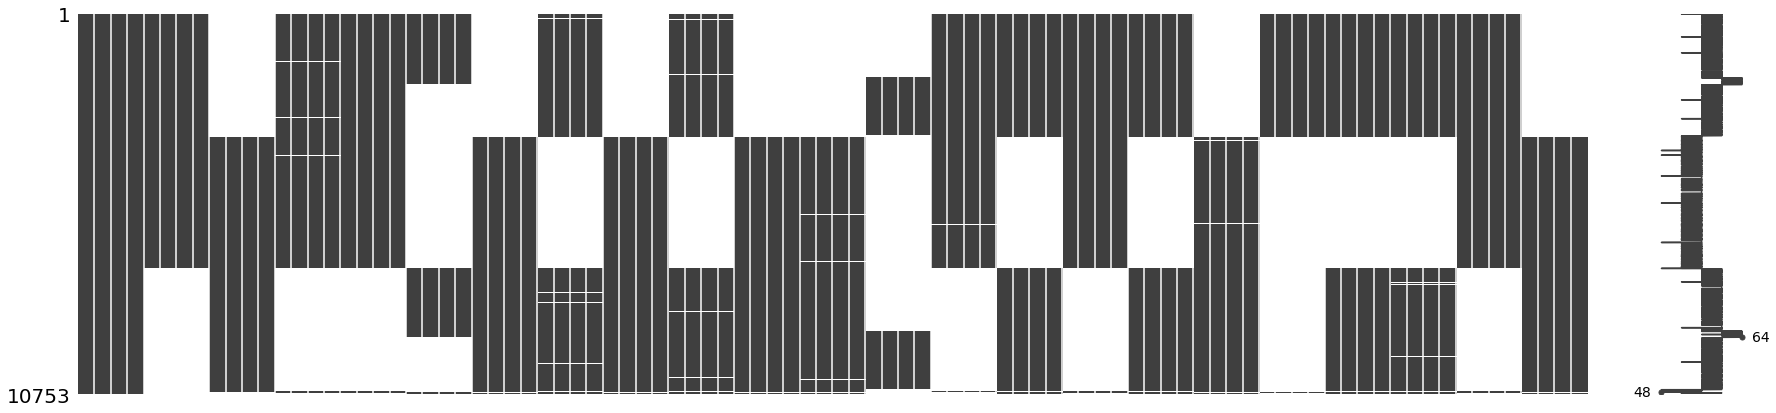

In [35]:
# Plot visualisation of the missing values for each feature of the DataFrame, df_training_match_msg_pvt
msno.matrix(df_training_match_msg_pvt, figsize = (30, 7))

<AxesSubplot:>

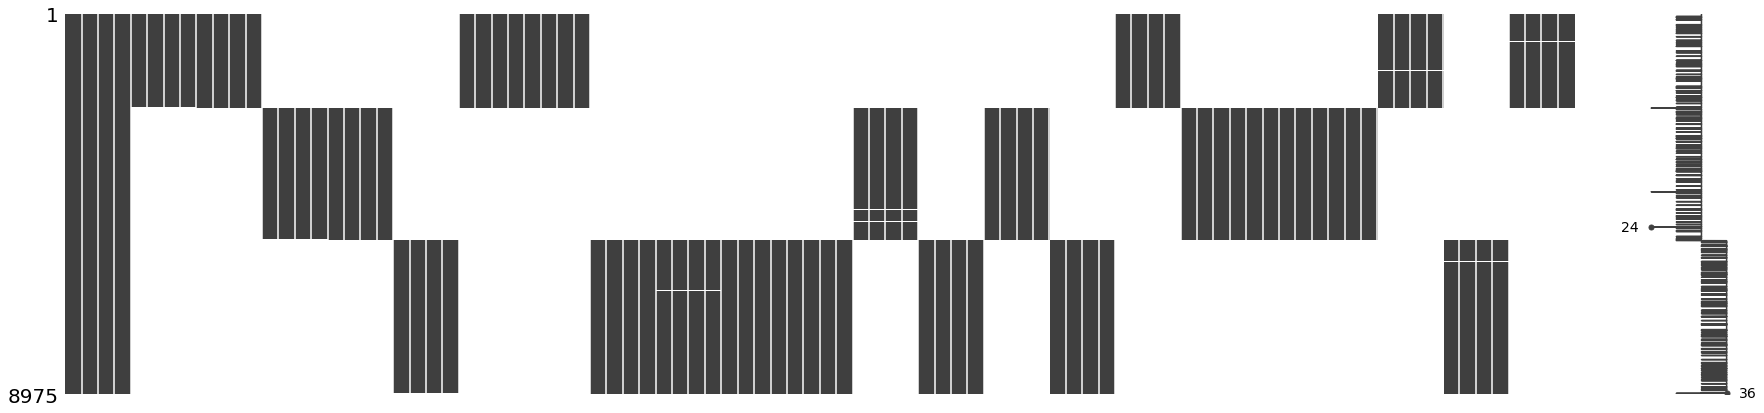

In [36]:
# Plot visualisation of the missing values for each feature of the DataFrame, df_training_crossing_and_finishing_hsr_spr_pvt
msno.matrix(df_training_crossing_and_finishing_hsr_spr_pvt, figsize = (30, 7))

<AxesSubplot:>

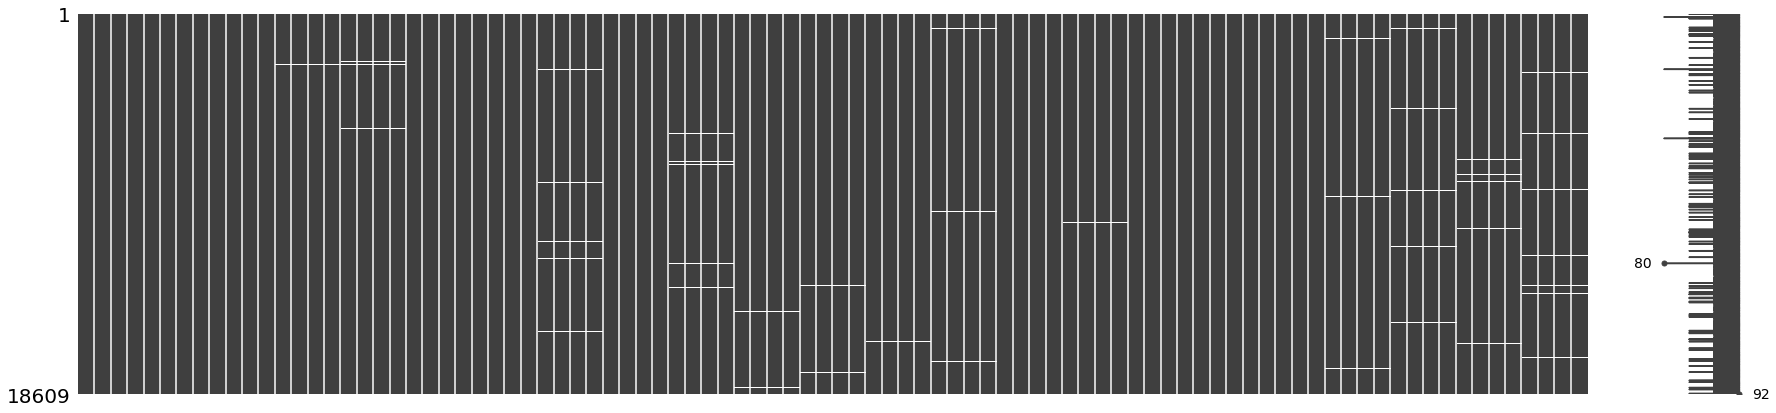

In [37]:
# Plot visualisation of the missing values for each feature of the DataFrame, df_training_attack_vs_defence_attack_superiority_pvt
msno.matrix(df_training_attack_vs_defence_attack_superiority_pvt, figsize = (30, 7))

<AxesSubplot:>

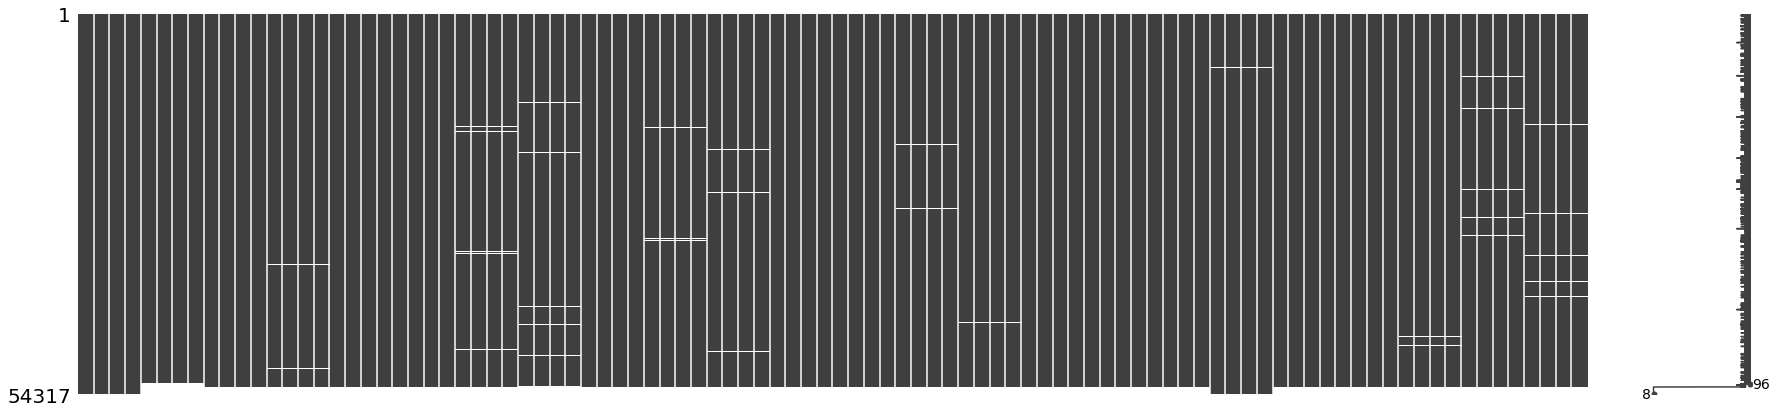

In [38]:
# Plot visualisation of the missing values for each feature of the DataFrame, df_training_full_session_modified_pvt
msno.matrix(df_training_full_session_modified_pvt, figsize = (30, 7))

<AxesSubplot:>

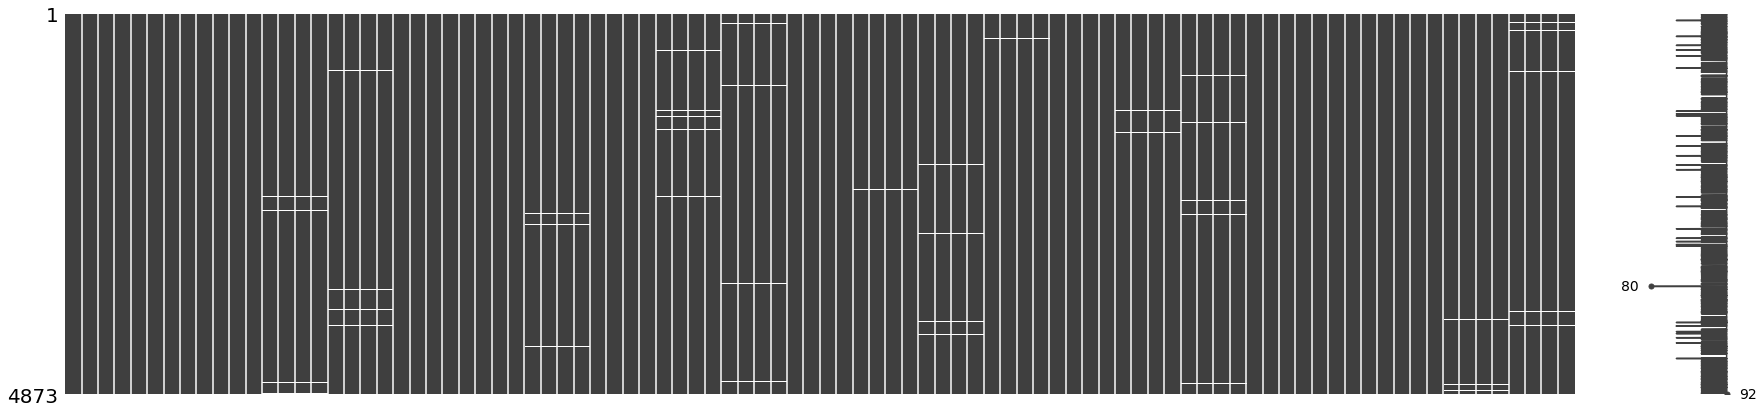

In [39]:
# Plot visualisation of the missing values for each feature of the DataFrame, df_training_passing_drill_physical_pvt
msno.matrix(df_training_passing_drill_physical_pvt, figsize = (30, 7))

<AxesSubplot:>

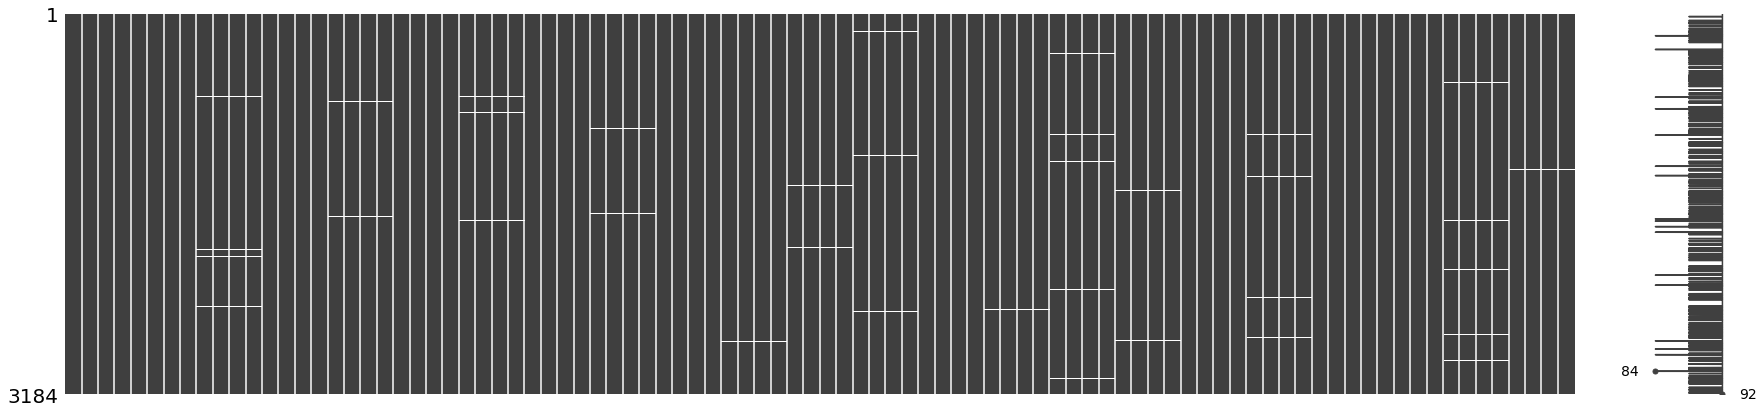

In [40]:
# Plot visualisation of the missing values for each feature of the DataFrame, df_training_warm_up_coordination_agility_pvt
msno.matrix(df_training_warm_up_coordination_agility_pvt, figsize = (30, 7))

From the visualisation, we can see that, that for certain drills, all the players are involved. However, for some drills the players are involved at different times

In [41]:
df_training_attack_vs_defence_attack_superiority_pvt.head(20)

,Frame,Time [s],Date,Training Drill,Ngakia_x,Ngakia_y,Ngakia Speed (m/s),Ngakia Speed (km/h),Cathcart_x,Cathcart_y,Cathcart Speed (m/s),Cathcart Speed (km/h),Etebo_x,Etebo_y,Etebo Speed (m/s),Etebo Speed (km/h),Dennis_x,Dennis_y,Dennis Speed (m/s),Dennis Speed (km/h),Kayembe_x,Kayembe_y,Kayembe Speed (m/s),Kayembe Speed (km/h),Baah_x,Baah_y,Baah Speed (m/s),Baah Speed (km/h),Sierralta_x,Sierralta_y,Sierralta Speed (m/s),Sierralta Speed (km/h),Ekong_x,Ekong_y,Ekong Speed (m/s),Ekong Speed (km/h),King_x,King_y,King Speed (m/s),King Speed (km/h),Kucka_x,Kucka_y,Kucka Speed (m/s),Kucka Speed (km/h),Kamara_x,Kamara_y,Kamara Speed (m/s),Kamara Speed (km/h),Fletcher_x,Fletcher_y,Fletcher Speed (m/s),Fletcher Speed (km/h),Louza_x,Louza_y,Louza Speed (m/s),Louza Speed (km/h),Gosling_x,Gosling_y,Gosling Speed (m/s),Gosling Speed (km/h),Femenia_x,Femenia_y,Femenia Speed (m/s),Femenia Speed (km/h),Samir_x,Samir_y,Samir Speed (m/s),Samir Speed (km/h),Joao Pedro_x,Joao Pedro_y,Joao Pedro Speed (m/s),Joao Pedro Speed (km/h),Sissoko_x,Sissoko_y,Sissoko Speed (m/s),Sissoko Speed (km/h),Kabasele_x,Kabasele_y,Kabasele Speed (m/s),Kabasele Speed (km/h),Masina_x,Masina_y,Masina Speed (m/s),Masina Speed (km/h),Kalu_x,Kalu_y,Kalu Speed (m/s),Kalu Speed (km/h),Sema_x,Sema_y,Sema Speed (m/s),Sema Speed (km/h)
0,0,12:08:24.2,2022-02-02,ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY,-0.281091,51.711385,0.0,0.0,-0.281124,51.711393,0.0,0.0,-0.281362,51.710896,1.055556,3.800003,-0.281581,51.711263,2.361113,8.500007,-0.281273,51.710967,0.0,0.0,-0.281057,51.711373,0.0,0.0,-0.281083,51.711350,0.0,0.0,-0.280962,51.711257,0.0,0.0,-0.281370,51.711195,1.927779,6.940006,-0.281566,51.711257,2.025002,7.290006,-0.281005,51.711463,0.558334,2.010002,-0.281284,51.711088,1.305557,4.700004,-0.281582,51.711126,1.575001,5.670005,-0.280963,51.711248,0.0,0.0,-0.281478,51.711305,1.105556,3.980003,-0.280984,51.711295,0.0,0.0,-0.281566,51.711311,1.950002,7.020006,-0.281447,51.711196,1.438890,5.180004,-0.281382,51.711224,0.741667,2.670002,-0.281316,51.711136,0.000000,0.000000,-0.281410,51.711047,1.594446,5.740005,-0.280945,51.711247,0.0,0.0
1,1,12:08:24.3,2022-02-02,ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY,-0.281091,51.711385,0.0,0.0,-0.281125,51.711393,0.0,0.0,-0.281362,51.710895,1.022223,3.680003,-0.281580,51.711263,1.075001,3.870003,-0.281273,51.710967,0.0,0.0,-0.281057,51.711373,0.0,0.0,-0.281083,51.711350,0.0,0.0,-0.280962,51.711257,0.0,0.0,-0.281372,51.711195,1.863890,6.710005,-0.281564,51.711257,1.175001,4.230003,-0.281006,51.711462,0.852778,3.070002,-0.281285,51.711089,1.261112,4.540004,-0.281581,51.711126,1.377779,4.960004,-0.280963,51.711248,0.0,0.0,-0.281477,51.711306,0.961112,3.460003,-0.280984,51.711295,0.0,0.0,-0.281564,51.711310,2.183335,7.860006,-0.281448,51.711197,1.466668,5.280004,-0.281381,51.711224,0.633334,2.280002,-0.281316,51.711136,0.000000,0.000000,-0.281410,51.711048,1.577779,5.680005,-0.280945,51.711247,0.0,0.0
2,2,12:08:24.4,2022-02-02,ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY,-0.281091,51.711385,0.0,0.0,-0.281124,51.711393,0.0,0.0,-0.281362,51.710894,0.950001,3.420003,-0.281579,51.711263,0.733334,2.640002,-0.281273,51.710966,0.0,0.0,-0.281057,51.711373,0.0,0.0,-0.281083,51.711350,0.0,0.0,-0.280962,51.711257,0.0,0.0,-0.281374,51.711196,1.863890,6.710005,-0.281564,51.711258,0.841667,3.030002,-0.281008,51.711462,1.019445,3.670003,-0.281287,51.711089,1.352779,4.870004,-0.281579,51.711126,1.047223,3.770003,-0.280963,51.711248,0.0,0.0,-0.281476,51.711307,1.566668,5.640005,-0.280984,51.711295,0.0,0.0,-0.281560,51.711309,2.572224,9.260007,-0.281449,51.711198,0.975001,3.510003,-0.281379,51.711225,1.480557,5.330004,-0.281316,51.711136,0.000000,0.000000,-0.281410,51.711050,1.472223,5.300004,-0.280945,51.711247,0.0,0.0
3,3,12:08:24.5,2022-02-02,ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY,-0.281091,51.711385,0.0,0.0,-0.281124,51.711393,0.0,0.0,-0.281362,51.710893,0.975001,3.510003,-0.281578,51.711262,0.847223,3.050002,-0.281273,51.710966,0.0,0.0,-0.281057,51.711373,0.0,0.0,-0.281083,51.711

<a id='section4.4'></a>

### <a id='#section4.4'>4.4. Calculate Speed, Distance, and Acceleration</a>

In [82]:
# Define function for calculating the velocities and accelerations of the training data using the x, y locations and timestep
def calc_player_velocities_accelerations(df, date='2022-02-02', training_drill='NOT-DEFINED', smoothing_v=True, smoothing_a=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12, dt=0.1):
    """ calc_player_velocities_accelerations( training data )
    
    Calculate player velocities in x & y direction, and total player speed at each timestamp of the tracking data
    
    Parameters
    -----------
        df: the tracking DataFrame
        smoothing_v: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing_v the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing_v window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN. 
        
    Returns
    -----------
       df : the tracking DataFrame with columns for speed in the x & y direction and total speed added

    """
    
    ## Read in exported CSV file if exists, if not, download the latest JSON data
    if not os.path.exists(os.path.join(data_dir_physical, 'engineered', 'Set 2', '4_modified_individual_training_sessions_dataset', f'{date}-{training_drill}-MOVEMENT-SPEED-ACCELERATION-TRAINING-DATA-ALL-PLAYERS.csv')):
    
    
        ### Start timer
        tic = datetime.datetime.now()

        
        ### Print time of engineering of tracking data started
        print(f'Calculation of each player\'s speed and accelerations for the {training_drill} started at: {tic}')        
        
        
        # Create columns
       #df['Date Time [s]'] = pd.to_datetime(df['Date'] + ' ' + df['Time [s]'])
        df['Period'] = 1

        # remove any velocity data already in the dataframe
        df = remove_player_velocities_accelerations(df)

        # Get the player ids
        player_ids = [col for col in df.columns if '_x' in col]
        player_ids = [s.replace('_x', '') for s in player_ids]

        # Calculate the timestep from one frame to the next - not required.
        #dt = df['Time [s]'].diff()
        #dt = df['Date Time [s]'].diff()

        # index of first frame in second half
        #second_half_idx = df.Period.idxmax(2)
        second_half_idx = df[df.Period == 2].first_valid_index()

        # estimate velocities for players in df
        for player in player_ids: # cycle through players individually
            # difference player positions in timestep dt to get unsmoothed estimate of velicity
            vx = df[player + '_x'].diff() / dt
            vy = df[player + '_y'].diff() / dt

            if maxspeed>0:
                # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
                raw_speed = np.sqrt( vx**2 + vy**2 )
               #acceleration = raw_speed.diff() / dt
                vx[ raw_speed>maxspeed ] = np.nan
                vy[ raw_speed>maxspeed ] = np.nan
           #if maxacc>0:
               #ax[ raw_acc>maxacc ] = np.nan
               #ay[ raw_acc>maxacc ] = np.nan
            if smoothing_v:
                if filter_=='Savitzky-Golay':
                    # calculate first half velocity
                    vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                    vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx],window_length=window,polyorder=polyorder)        
                    # calculate second half velocity
                    vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                    vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                elif filter_=='moving average':
                    ma_window = np.ones( window ) / window 
                    # calculate first half velocity
                    vx.loc[:second_half_idx] = np.convolve( vx.loc[:second_half_idx], ma_window, mode='same') 
                    vy.loc[:second_half_idx] = np.convolve( vy.loc[:second_half_idx], ma_window, mode='same')      
                    # calculate second half velocity
                    vx.loc[second_half_idx:] = np.convolve( vx.loc[second_half_idx:], ma_window, mode='same') 
                    vy.loc[second_half_idx:] = np.convolve( vy.loc[second_half_idx:], ma_window, mode='same') 
                   #speed = ( vx**2 + vy**2 )**.5
                   #acceleration = np.diff(speed) / dt
                   #ax = np.convolve( ax, ma_window, mode='same' ) 
                   #ay = np.convolve( ay, ma_window, mode='same' )              
                   # put player speed in x, y direction, and total speed back in the data frame

            # put player speed in x, y direction, and total speed back in the data frame
            df[player + '_vx'] = vx
            df[player + '_vy'] = vy
            df[player + '_speed'] = np.sqrt(vx**2 + vy**2)
           #df[player + '_ax'] = ax
           #df[player + '_ay'] = ay
           #df[player + '_rawspeed'] = raw_speed
           #df[player + '_rawacc'] = raw_acc
            df[player + '_speed'] = np.sqrt(vx**2 + vy**2)
            # Calculate acceleration - method 1, using speed calculated
           #acceleration = df[player + '_speed'].diff() / dt
           #df[player + '_acceleration'] = acceleration
            # Calculate acceleration - method 2, using speed provided
            acceleration = df[player + ' Speed (m/s)'].diff() / dt
           #acceleration = (df[player + ' Speed (m/s)'] - df[player + ' Speed (m/s)'].shift()) / 0.1
            df[player + ' Acceleration (m/s/s)'] = acceleration 
            if smoothing_a:
                ma_window = np.ones( window ) / window 
                df[player + ' Acceleration (m/s/s)'] = np.convolve( acceleration, ma_window, mode='same')  
                
        
        ### Save DataFrame

        #### Define filename for each combined file to be saved
        save_filename = f'{date}-{training_drill}-MOVEMENT-SPEED-ACCELERATION-TRAINING-DATA-ALL-PLAYERS'.replace(' ', '-').replace('(', '').replace(')', '').replace(':', '').replace('.', '').replace('__', '_').upper()

        #### Define the filepath to save each combined file
        path = os.path.join(data_dir_physical, 'engineered', 'Set 2', '4_modified_individual_training_sessions_dataset')

        #### Save the combined file as a CSV
        df.to_csv(path + f'/{save_filename}.csv', index=None, header=True)
        
        
        ### End timer
        toc = datetime.datetime.now()
    
    
        ### Print time of engineering of tracking data ended
        print(f'Calculation of each player\'s speed and accelerations for the {training_drill} ended at: {toc}')


        ### Calculate time take
        total_time = (toc-tic).total_seconds()
        print(f'Time taken to calculate speed and acceleration and save the training data is: {total_time:0.2f} seconds.')
        
    
    
    ## If CSV file already exists, read in previously saved DataFrame
    else:
        
        ### Print time reading of CSV files started
        print('Training data with calculated velocities and accelerations already saved to local storage. Reading in file as a pandas DataFrame.')
        
        ### Read in raw DataFrame
        df = pd.read_csv(os.path.join(data_dir_physical, 'engineered', 'Set 2', '4_modified_individual_training_sessions_dataset', f'{date}-{training_drill}-MOVEMENT-SPEED-ACCELERATION-TRAINING-DATA-ALL-PLAYERS.csv'))
        
        
    ## Return the DataFrame
    return(df)

def remove_player_velocities_accelerations(df):
    # remove player velocities and acceleration measures that are already in the 'df' dataframe
    columns = [c for c in df.columns if c.split('_')[-1] in ['vx', 'vy', 'ax', 'ay', 'rawspeed', 'rawacc', 'speed', 'acceleration']]    # Get the player ids
    df = df.drop(columns=columns)
    return df

In [84]:
# Calculate the velocity and accelerations for each player in each of the six training sessions
df_training_match_msg_vel = calc_player_velocities_accelerations(df=df_training_match_msg_pvt, date='2022-02-02', training_drill='MATCH-MSG', smoothing_v=True, smoothing_a=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12, dt=0.1)
df_training_crossing_and_finishing_hsr_spr_vel = calc_player_velocities_accelerations(df=df_training_crossing_and_finishing_hsr_spr_pvt, date='2022-02-02', training_drill='CROSSING-AND-FINISHING-HSR-SPR', smoothing_v=True, smoothing_a=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12, dt=0.1)
df_training_attack_vs_defence_attack_superiority_vel = calc_player_velocities_accelerations(df=df_training_attack_vs_defence_attack_superiority_pvt, date='2022-02-02', training_drill='ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY', smoothing_v=True, smoothing_a=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12, dt=0.1)
df_training_full_session_modified_vel = calc_player_velocities_accelerations(df=df_training_full_session_modified_pvt, date='2022-02-02', training_drill='FULL-SESSION-MODIFIED', smoothing_v=True, smoothing_a=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12, dt=0.1)
df_training_passing_drill_physical_vel = calc_player_velocities_accelerations(df=df_training_passing_drill_physical_pvt, date='2022-02-02', training_drill='PASSING-DRILL-PHYSICAL', smoothing_v=True, smoothing_a=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12, dt=0.1)
df_training_warm_up_coordination_agility_vel = calc_player_velocities_accelerations(df=df_training_warm_up_coordination_agility_pvt, date='2022-02-02', training_drill='WARM-UP-COORDINATION-AGILITY', smoothing_v=True, smoothing_a=True, filter_='moving_average', window=7, polyorder=1, maxspeed=12, dt=0.1)

Calculation of each player's speed and accelerations for the MATCH-MSG started at: 2022-02-15 23:02:52.807892
Calculation of each player's speed and accelerations for the MATCH-MSG ended at: 2022-02-15 23:02:55.054667
Time taken to calculate speed and acceleration and save the training data is: 2.25 seconds.
Calculation of each player's speed and accelerations for the CROSSING-AND-FINISHING-HSR-SPR started at: 2022-02-15 23:02:55.056062
Calculation of each player's speed and accelerations for the CROSSING-AND-FINISHING-HSR-SPR ended at: 2022-02-15 23:02:56.524802
Time taken to calculate speed and acceleration and save the training data is: 1.47 seconds.
Calculation of each player's speed and accelerations for the ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY started at: 2022-02-15 23:02:56.528356
Calculation of each player's speed and accelerations for the ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY ended at: 2022-02-15 23:03:01.069064
Time taken to calculate speed and acceleration and save the traini

In [44]:
sorted(df_training_attack_vs_defence_attack_superiority_vel.columns)

['Baah Acceleration (m/s/s)',
 'Baah Speed (km/h)',
 'Baah Speed (m/s)',
 'Baah_acceleration',
 'Baah_speed',
 'Baah_vx',
 'Baah_vy',
 'Baah_x',
 'Baah_y',
 'Cathcart Acceleration (m/s/s)',
 'Cathcart Speed (km/h)',
 'Cathcart Speed (m/s)',
 'Cathcart_acceleration',
 'Cathcart_speed',
 'Cathcart_vx',
 'Cathcart_vy',
 'Cathcart_x',
 'Cathcart_y',
 'Date',
 'Dennis Acceleration (m/s/s)',
 'Dennis Speed (km/h)',
 'Dennis Speed (m/s)',
 'Dennis_acceleration',
 'Dennis_speed',
 'Dennis_vx',
 'Dennis_vy',
 'Dennis_x',
 'Dennis_y',
 'Ekong Acceleration (m/s/s)',
 'Ekong Speed (km/h)',
 'Ekong Speed (m/s)',
 'Ekong_acceleration',
 'Ekong_speed',
 'Ekong_vx',
 'Ekong_vy',
 'Ekong_x',
 'Ekong_y',
 'Etebo Acceleration (m/s/s)',
 'Etebo Speed (km/h)',
 'Etebo Speed (m/s)',
 'Etebo_acceleration',
 'Etebo_speed',
 'Etebo_vx',
 'Etebo_vy',
 'Etebo_x',
 'Etebo_y',
 'Femenia Acceleration (m/s/s)',
 'Femenia Speed (km/h)',
 'Femenia Speed (m/s)',
 'Femenia_acceleration',
 'Femenia_speed',
 'Femenia_vx',

In [64]:
# Display DataFrame - ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY
df_training_attack_vs_defence_attack_superiority_vel.head()

,Frame,Time [s],Date,Training Drill,Ngakia_x,Ngakia_y,Ngakia Speed (m/s),Ngakia Speed (km/h),Cathcart_x,Cathcart_y,Cathcart Speed (m/s),Cathcart Speed (km/h),Etebo_x,Etebo_y,Etebo Speed (m/s),Etebo Speed (km/h),Dennis_x,Dennis_y,Dennis Speed (m/s),Dennis Speed (km/h),Kayembe_x,Kayembe_y,Kayembe Speed (m/s),Kayembe Speed (km/h),Baah_x,Baah_y,Baah Speed (m/s),Baah Speed (km/h),Sierralta_x,Sierralta_y,Sierralta Speed (m/s),Sierralta Speed (km/h),Ekong_x,Ekong_y,Ekong Speed (m/s),Ekong Speed (km/h),King_x,King_y,King Speed (m/s),King Speed (km/h),Kucka_x,Kucka_y,Kucka Speed (m/s),Kucka Speed (km/h),Kamara_x,Kamara_y,Kamara Speed (m/s),Kamara Speed (km/h),Fletcher_x,Fletcher_y,Fletcher Speed (m/s),Fletcher Speed (km/h),Louza_x,Louza_y,Louza Speed (m/s),Louza Speed (km/h),Gosling_x,Gosling_y,Gosling Speed (m/s),Gosling Speed (km/h),Femenia_x,Femenia_y,Femenia Speed (m/s),Femenia Speed (km/h),Samir_x,Samir_y,Samir Speed (m/s),Samir Speed (km/h),Joao Pedro_x,Joao Pedro_y,Joao Pedro Speed (m/s),Joao Pedro Speed (km/h),Sissoko_x,Sissoko_y,Sissoko Speed (m/s),Sissoko Speed (km/h),Kabasele_x,Kabasele_y,Kabasele Speed (m/s),Kabasele Speed (km/h),Masina_x,Masina_y,Masina Speed (m/s),Masina Speed (km/h),Kalu_x,Kalu_y,Kalu Speed (m/s),Kalu Speed (km/h),Sema_x,Sema_y,Sema Speed (m/s),Sema Speed (km/h),Period,Ngakia_vx,Ngakia_vy,Ngakia_speed,Ngakia Acceleration (m/s/s),Cathcart_vx,Cathcart_vy,Cathcart_speed,Cathcart Acceleration (m/s/s),Etebo_vx,Etebo_vy,Etebo_speed,Etebo Acceleration (m/s/s),Dennis_vx,Dennis_vy,Dennis_speed,Dennis Acceleration (m/s/s),Kayembe_vx,Kayembe_vy,Kayembe_speed,Kayembe Acceleration (m/s/s),Baah_vx,Baah_vy,Baah_speed,Baah Acceleration (m/s/s),Sierralta_vx,Sierralta_vy,Sierralta_speed,Sierralta Acceleration (m/s/s),Ekong_vx,Ekong_vy,Ekong_speed,Ekong Acceleration (m/s/s),King_vx,King_vy,King_speed,King Acceleration (m/s/s),Kucka_vx,Kucka_vy,Kucka_speed,Kucka Acceleration (m/s/s),Kamara_vx,Kamara_vy,Kamara_speed,Kamara Acceleration (m/s/s),Fletcher_vx,Fletcher_vy,Fletcher_speed,Fletcher Acceleration (m/s/s),Louza_vx,Louza_vy,Louza_speed,Louza Acceleration (m/s/s),Gosling_vx,Gosling_vy,Gosling_speed,Gosling Acceleration (m/s/s),Femenia_vx,Femenia_vy,Femenia_speed,Femenia Acceleration (m/s/s),Samir_vx,Samir_vy,Samir_speed,Samir Acceleration (m/s/s),Joao Pedro_vx,Joao Pedro_vy,Joao Pedro_speed,Joao Pedro Acceleration (m/s/s),Sissoko_vx,Sissoko_vy,Sissoko_speed,Sissoko Acceleration (m/s/s),Kabasele_vx,Kabasele_vy,Kabasele_speed,Kabasele Acceleration (m/s/s),Masina_vx,Masina_vy,Masina_speed,Masina Acceleration (m/s/s),Kalu_vx,Kalu_vy,Kalu_speed,Kalu Acceleration (m/s/s),Sema_vx,Sema_vy,Sema_speed,Sema Acceleration (m/s/s)
0,0,12:08:24.2,2022-02-02,ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY,-0.281091,51.711385,0.0,0.0,-0.281124,51.711393,0.0,0.0,-0.281362,51.710896,1.055556,3.800003,-0.281581,51.711263,2.361113,8.500007,-0.281273,51.710967,0.0,0.0,-0.281057,51.711373,0.0,0.0,-0.281083,51.71135,0.0,0.0,-0.280962,51.711257,0.0,0.0,-0.281370,51.711195,1.927779,6.940006,-0.281566,51.711257,2.025002,7.290006,-0.281005,51.711463,0.558334,2.010002,-0.281284,51.711088,1.305557,4.700004,-0.281582,51.711126,1.575001,5.670005,-0.280963,51.711248,0.0,0.0,-0.281478,51.711305,1.105556,3.980003,-0.280984,51.711295,0.0,0.0,-0.281566,51.711311,1.950002,7.020006,-0.281447,51.711196,1.438890,5.180004,-0.281382,51.711224,0.741667,2.670002,-0.281316,51.711136,0.0,0.0,-0.28141,51.711047,1.594446,5.740005,-0.280945,51.711247,0.0,0.0,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.023811,NaN,NaN,NaN,21.269858,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.222224,NaN,NaN,NaN,19.285730,NaN,NaN,NaN,-6.547624,NaN,NaN,NaN,-2.539685,NaN,NaN,NaN,12.777788,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.825398,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-18.333348,NaN,NaN,NaN,7.420641,NaN,NaN,NaN,-9.484135,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-7.103180,NaN,NaN,NaN,0.0
1,1,12:08:24.3,2022-02-02,ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY,-0.281091,51.711385,0.0,0.0,-0.281125,51.

<a id='section4.5'></a>

### <a id='#section4.5'>4.5. Create Physical Reports for Each Individual Training Session</a>
The speed zones are defined as:
*    Low-Speed Activities (LSA) (<14 km/h or <4 m/s);
*    Moderate-Speed Running (MSR) (14.4–19.8 km/h or 4-5.5 m/s);
*    High-Speed Running (HSR) (19.8–25.1 km/h or 5.5-6.972 m/s); and
*    Sprinting (≥25.2 km km/h or ≥6.972 m/s).

For further information, see: [Application of Individualized Speed Zones to Quantify External Training Load in Professional Soccer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7126260/) by Vincenzo Rago, João Brito, Pedro Figueiredo, Peter Krustrup, and António Rebelo.

In [89]:
# Define a function to generate a bespoke physical summary of all the players for an individual training session
def create_physical_report_per_training_session(df, date='2022-02-02', training_drill='NOT-DEFINED'):
    
    """
    Define a function to generate a bespoke physical summary of all the players for an individual training session
    """
    
    ## Read in exported CSV file if exists, if not, download the latest JSON data
    if not os.path.exists(os.path.join(data_dir_physical, 'engineered', 'Set 2', '5_physical_reports', f'{date}-{training_drill}-PHYSICAL-REPORT-ALL-PLAYERS.csv')):
    
    
        ### Start timer
        tic = datetime.datetime.now()

        
        ### Print time of engineering of tracking data started
        print(f'Creation of the physical report for the {training_drill} training drill started at: {tic}')        
    
    
        ## Data Engineering

        ### 
        lst_cols = list(df)

        ###
        lst_players = []

        ###
        for col in lst_cols:
            if '_x' in col:
                col = col.replace('_x', '')
                lst_players.append(col)

        ### Create DataFrame where each row is a player
        df_summary = pd.DataFrame(lst_players, columns=['Player'])

        
    
        ##
        df_summary['Date'] = date        
        df_summary['Training Drill'] = training_drill
    

    
        ## Calculate minutes played for each player

        ### Create empty list for minutes
        lst_minutes = []

        ### Cycle through each player's jersey number in the team and look for the first and last time for each player
        for player in lst_players:

            #### Search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
            column = f'{player}' + '_x'     # use player x-position coordinate
            try:
                player_minutes = (df[column].last_valid_index() - df[column].first_valid_index() + 1) / 10 / 60     # convert to minutes
            except:
                player_minutes = 0
            lst_minutes.append(player_minutes)

        ### Create column for the minute played
        df_summary['Minutes Trained'] = lst_minutes

        ### Sort values by minutes played descending
        df_summary = df_summary.sort_values(['Minutes Trained'], ascending=False)



        ## Calculate total distance covered for each player

        ### Create empty list for distance
        lst_distance = []

        ### Cycle through each player and multiple their speed at any given instance by 10ms to get total distance and divide by 1,000 to get this in km
        for player in lst_players:
            column = f'{player}' + ' Speed (m/s)'
            df_player_distance = df[column].sum()/100./1000          # speed time. Convert to km (original logic)
           #df_player_distance = (df[column].sum() * 0.01) / 1000    # Distance = Speed * Time
            lst_distance.append(df_player_distance)

        ### Create column for the distance in km
        df_summary['Distance [km]'] = lst_distance

        

        ## Calculate total distance covered for each player for different types of movement

        ### Create empty lists for distances of different movements
        lst_lsa = []
        lst_msr = []
        lst_hsr = []
        lst_sprinting = []

        ### Cycle through each player's jersey number in the team and 
        for player in lst_players:
            column = f'{player}' + ' Speed (m/s)'
            ### Low-Speed Activities (LSA) (<14 km/h or <4 m/s)
            player_distance = df.loc[df[column] < 4, column].sum()/100./1000
           #player_distance = df.loc[df[column] < 14.4, column].sum()/100./1000
            lst_lsa.append(player_distance)
            ### Moderate-Speed Running (MSR) (14.4–19.8 km/h or 4-5.5 m/s)
            player_distance = df.loc[(df[column] >= 4) & (df[column] < 5.5), column].sum()/100./1000
           #player_distance = df.loc[(df[column] >= 14.4) & (df[column] < 19.8), column].sum()/100./1000
            lst_msr.append(player_distance)
            ### High-Speed Running (HSR) (19.8–25.1 km/h or 5.5-6.972 m/s)
            player_distance = df.loc[(df[column] >= 5.5) & (df[column] < 6.972222), column].sum()/100./1000
           #player_distance = df.loc[(df[column] >= 19.8) & (df[column] < 25.1), column].sum()/100./1000
            lst_hsr.append(player_distance)
            ### Sprinting (≥25.2 km km/h or ≥6.972 m/s)
            player_distance = df.loc[df[column] >= 6.972222, column].sum()/100./1000
           #player_distance = df.loc[df[column] >= 25.2, column].sum()/100./1000
            lst_sprinting.append(player_distance)

        ### Assign each movement list to a column in the Summary DataFrame
        df_summary['Low-Speed Activities (LSA) [km]'] = lst_lsa
        df_summary['Moderate-Speed Running (MSR) [km]'] = lst_msr
        df_summary['High-Speed Running (HSR) [km]'] = lst_hsr
        df_summary['Sprinting [km]'] = lst_sprinting

        
        
        ## Reset index
        df_summary = df_summary.reset_index(drop=True)

        
        
        ## Determine the number of sustained sprints per match

        ### Create an empty list for the number of sprints
        nsprints = []

        ###
       #sprint_threshold = 25.2        # minimum speed to be defined as a sprint (km/h)
        sprint_threshold = 6.972222    # minimum speed to be defined as a sprint (m/s)
        sprint_window = 1 * 10

        ###
        for player in lst_players:
            column = f'{player}' + ' Speed (m/s)'
            # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
            # diff helps us to identify when the window starts
            player_sprints = np.diff(1 * (np.convolve(1 * (df[column] >= sprint_threshold), np.ones(sprint_window), mode='same') >= sprint_window))
            nsprints.append(np.sum(player_sprints == 1 ))

        ### Add column for the number of sprints
        df_summary['No. Sprints'] = nsprints


        
        ## Estimate the top speed of each player

        ### Create empty dictionary to append maximum speeds
        dict_top_speeds = {}

        ### Iterate through the columns of the training DataFrame for the top speeds
        player_speed_columns = [i for i in df.columns if ' Speed (m/s)' in i]

        ### Iterate through all the rows of all the speed columns, to determine the maximum speed for each player
        for player in player_speed_columns:
            dict_top_speeds[player] = df[player].max()

        ### 
        df_top_speeds = pd.DataFrame.from_dict(dict_top_speeds, orient='index', columns=['Top Speed [m/s]'])

        ### 
        df_top_speeds = df_top_speeds.reset_index(drop=False)

        ### 
        df_top_speeds = df_top_speeds.rename(columns={'index': 'Player'})

        ### 
        df_top_speeds['Player'] = df_top_speeds['Player'].str.replace(' Speed (m/s)', '')

        ### 
        df_top_speeds['Player'] = df_top_speeds['Player'].str.replace(' Speed \(m/s\)', '')

        ### Merge Top Speeds DataFrame to Summary DataFrame
        df_summary = pd.merge(df_summary, df_top_speeds, left_on=['Player'], right_on=['Player'], how='left')
        
        
        
        ## Estimate the top acceleration of each player

        ### Create empty dictionary to append maximum accelerations
        dict_top_accelerations = {}

        ### Iterate through the columns of the training DataFrame for the top accelerations
        player_acceleration_columns = [i for i in df.columns if ' Acceleration (m/s/s)' in i]

        ### Iterate through all the rows of all the acceleration columns, to determine the maximum acceleration for each player
        for player in player_acceleration_columns:
            dict_top_accelerations[player] = df[player].max()

        ### 
        df_top_accelerations = pd.DataFrame.from_dict(dict_top_accelerations, orient='index', columns=['Top Acceleration [m/s/s]'])

        ### 
        df_top_accelerations = df_top_accelerations.reset_index(drop=False)

        ### 
        df_top_accelerations = df_top_accelerations.rename(columns={'index': 'Player'})

        ### 
        df_top_accelerations['Player'] = df_top_accelerations['Player'].str.replace(' Acceleration (m/s/s)', '')

        ### 
        df_top_accelerations['Player'] = df_top_accelerations['Player'].str.replace(' Acceleration \(m/s/s\)', '')
        
        ### Merge Top Speeds DataFrame to Summary DataFrame
        df_summary = pd.merge(df_summary, df_top_accelerations, left_on=['Player'], right_on=['Player'], how='left')
        

        ### Save DataFrame

        #### Define filename for each combined file to be saved
        save_filename = f'{date}-{training_drill}-PHYSICAL-REPORT-ALL-PLAYERS'.replace(' ', '-').replace('(', '').replace(')', '').replace(':', '').replace('.', '').replace('__', '_').upper()

        #### Define the filepath to save each combined file
        path = os.path.join(data_dir_physical, 'engineered', 'Set 2', '5_physical_reports')

        #### Save the combined file as a CSV
        df_summary.to_csv(path + f'/{save_filename}.csv', index=None, header=True)
        
        
        ### End timer
        toc = datetime.datetime.now()
    
    
        ### Print time of engineering of tracking data ended
        print(f'Creation of the physical report for the {training_drill} training drill ended at: {toc}')


        ### Calculate time take
        total_time = (toc-tic).total_seconds()
        print(f'Time taken to create the physical report for the {training_drill} training data is: {total_time:0.2f} seconds.')
        
    
    
    ## If CSV file already exists, read in previously saved DataFrame
    else:
        
        ### Print time reading of CSV files started
        print('Physical report already saved to local storage. Reading in file as a pandas DataFrame.')
        
        ### Read in raw DataFrame
        df_summary = pd.read_csv(os.path.join(data_dir_physical, 'engineered', 'Set 2', '5_physical_reports', f'{date}-{training_drill}-PHYSICAL-REPORT-ALL-PLAYERS.csv'))
    
    
    ## Return DataFrame
    return df_summary

In [90]:
# Create physical reports for each player in each of the six training sessions
df_training_match_msg_physical_report = create_physical_report_per_training_session(df_training_match_msg_vel, date='2022-02-02', training_drill='MATCH-MSG')
df_training_crossing_and_finishing_hsr_spr_physical_report = create_physical_report_per_training_session(df_training_crossing_and_finishing_hsr_spr_vel, date='2022-02-02', training_drill='CROSSING-AND-FINISHING-HSR-SPR')
df_training_attack_vs_defence_attack_superiority_physical_report = create_physical_report_per_training_session(df_training_attack_vs_defence_attack_superiority_vel, date='2022-02-02', training_drill='ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY')
df_training_full_session_modified_physical_report = create_physical_report_per_training_session(df_training_full_session_modified_vel, date='2022-02-02', training_drill='FULL-SESSION-MODIFIED')
df_training_passing_drill_physical_physical_report = create_physical_report_per_training_session(df_training_passing_drill_physical_vel, date='2022-02-02', training_drill='PASSING-DRILL-PHYSICAL')
df_training_warm_up_coordination_agility_physical_report = create_physical_report_per_training_session(df_training_warm_up_coordination_agility_vel, date='2022-02-02', training_drill='WARM-UP-COORDINATION-AGILITY')

Creation of the physical report for the MATCH-MSG training drill started at: 2022-02-15 23:03:43.902718
Creation of the physical report for the MATCH-MSG training drill ended at: 2022-02-15 23:03:44.007419
Time taken to create the physical report for the MATCH-MSG training data is: 0.10 seconds.
Creation of the physical report for the CROSSING-AND-FINISHING-HSR-SPR training drill started at: 2022-02-15 23:03:44.008334
Creation of the physical report for the CROSSING-AND-FINISHING-HSR-SPR training drill ended at: 2022-02-15 23:03:44.080399
Time taken to create the physical report for the CROSSING-AND-FINISHING-HSR-SPR training data is: 0.07 seconds.
Creation of the physical report for the ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY training drill started at: 2022-02-15 23:03:44.080718
Creation of the physical report for the ATTACK-VS-DEFENCE-ATTACK-SUPERIORITY training drill ended at: 2022-02-15 23:03:44.179410
Time taken to create the physical report for the ATTACK-VS-DEFENCE-ATTACK-SUPERIORI

<a id='section4.6'></a>

### <a id='#section4.6'>4.6. Create Single Physical Report for the Day of Interest</a>

In [91]:
# Define a function to generate a bespoke physical summary of all the players for an individual training session
def create_physical_report_per_day(date):
    
    """
    Define a function to generate a bespoke physical summary of all the players for an individual training session
    """
    
    ## Read in exported CSV file if exists, if not, download the latest JSON data
    if not os.path.exists(os.path.join(data_dir_physical, 'engineered', 'Set 2', '5_physical_reports', f'{date}-ALL-TRAINING-SESSIONS-PHYSICAL-REPORT-ALL-PLAYERS.csv')):
    
    
        ### Start timer
        tic = datetime.datetime.now()

        
        ### Print time of engineering of tracking data started
        print(f'Creation a single training report for {date} started at: {tic}')        


        ### List all files available
        lst_all_files = glob.glob(os.path.join(data_dir_physical, 'engineered', 'Set 2', '5_physical_reports', f'{date}*-PHYSICAL-REPORT-ALL-PLAYERS.csv'))


        ### Create an empty list to append individual DataFrames
        lst_files_to_append =[]


        ### Iterate through each file in list of all files
        for file in lst_all_files:

            ### Create temporary DataFrame with each file
            df_temp = pd.read_csv(file, index_col=None, header=0)

            ### Append each individual Define each individual file to the empty list (to be concatenated) 
            lst_files_to_append.append(df_temp)


        ### Concatenate all the files
        df_day_training_report = pd.concat(lst_files_to_append, axis=0, ignore_index=True)


        ### Save DataFrame

        #### Define filename for each combined file to be saved
        save_filename = f'{date}-ALL-TRAINING-SESSIONS-PHYSICAL-REPORT-ALL-PLAYERS'.replace(' ', '-').replace('(', '').replace(')', '').replace(':', '').replace('.', '').replace('__', '_').upper()

        #### Define the filepath to save each combined file
        path = os.path.join(data_dir_physical, 'engineered', 'Set 2', '5_physical_reports')

        #### Save the combined file as a CSV
        df_day_training_report.to_csv(path + f'/{save_filename}.csv', index=None, header=True)


        ### Engineer the data

        #### 
        df_day_training_report['Date'] = date
    
    
        ### End timer
        toc = datetime.datetime.now()
    
    
        ### Print time reading of CSV files end
        print(f'Creation a single training report for {date} ended at: {toc}')


        ### Calculate time take
        total_time = (toc-tic).total_seconds()
        print(f'Time taken create a single training report for {date} is: {total_time:0.2f} seconds.')

    
    
    ## If CSV file already exists, read in previously saved DataFrame
    else:
        
        ### Print time reading of CSV files started
        print('CSV file already saved to local storage. Reading in file as a pandas DataFrame.')
        
        ### Read in raw DataFrame
        df_day_training_report = pd.read_csv(os.path.join(data_dir_physical, 'engineered', 'Set 2', '5_physical_reports', f'{date}-ALL-TRAINING-SESSIONS-PHYSICAL-REPORT-ALL-PLAYERS.csv'))

    
    ## Return DataFrame
    return df_day_training_report

In [92]:
df_training_report_02022022 = create_physical_report_per_day(date='2022-02-02')

Creation a single training report for 2022-02-02 started at: 2022-02-15 23:03:50.916918
Creation a single training report for 2022-02-02 ended at: 2022-02-15 23:03:50.939939
Time taken create a single training report for 2022-02-02 is: 0.02 seconds.


In [93]:
df_training_report_02022022.head(10)

,Player,Date,Training Drill,Minutes Trained,Distance [km],Low-Speed Activities (LSA) [km],Moderate-Speed Running (MSR) [km],High-Speed Running (HSR) [km],Sprinting [km],No. Sprints,Top Speed [m/s],Top Acceleration [m/s/s]
0,Ngakia,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.047011,0.041150,0.003905,0.001956,0.0,0,6.797228,6.011910
1,Masina,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.043365,0.038872,0.002948,0.001545,0.0,0,6.480561,5.611116
2,Etebo,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.044917,0.040510,0.002968,0.001439,0.0,0,6.141672,5.416671
3,Samir,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.044136,0.040443,0.002799,0.000894,0.0,0,5.597227,6.210322
4,Kayembe,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.042606,0.039897,0.002596,0.000114,0.0,0,6.291672,4.992067
5,Kalu,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.043508,0.039836,0.002241,0.001432,0.0,0,5.888894,4.976194
6,Joao Pedro,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.046932,0.042358,0.003036,0.001538,0.0,0,6.913894,5.519846
7,Kabasele,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.046264,0.042153,0.002750,0.001361,0.0,0,6.444450,5.480163
8,Sierralta,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.044885,0.040096,0.003365,0.001424,0.0,0,5.866671,6.813498
9,King,2022-02-02,WARM-UP-COORDINATION-AGILITY,5.306667,0.046201,0.042388,0.002612,0.001202,0.0,0,6.011116,4.309527


In [54]:
df_training_report_02022022.shape

(133, 12)

---

<a id='section5'></a>

## <a id='#section5'>5. Summary</a>
This notebook engineer physical data using [pandas](http://pandas.pydata.org/) to create a series of training reports for players, determining metrics include distance covered, total sprints, top speeds, amoungst other breakdowns.

---

<a id='section6'></a>

## <a id='#section6'>6. Next Steps</a>
The next stage is to visualise this data in Tableau and analyse the findings, to be presented in a deck.

---

<a id='section7'></a>

## <a id='#section7'>7. References</a>
*    [Application of Individualized Speed Zones to Quantify External Training Load in Professional Soccer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7126260/) by Vincenzo Rago, João Brito, Pedro Figueiredo, Peter Krustrup, and António Rebelo.
*    [Laurie Shaw](https://twitter.com/EightyFivePoint)'s Metrica Sports Tracking data libraries, [`LaurieOnTracking`](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking)

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)